# Image generation with Stable Diffusion v3 and OpenVINO

Stable Diffusion V3 is next generation of latent diffusion image Stable Diffusion models family that  outperforms state-of-the-art text-to-image generation systems in typography and prompt adherence, based on human preference evaluations. In comparison with previous versions, it based on Multimodal Diffusion Transformer (MMDiT) text-to-image model that features greatly improved performance in image quality, typography, complex prompt understanding, and resource-efficiency.

![mmdit.png](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/dd079427-89f2-4d28-a10e-c80792d750bf)

More details about model can be found in [model card](https://huggingface.co/stabilityai/stable-diffusion-3-medium), [research paper](https://stability.ai/news/stable-diffusion-3-research-paper) and [Stability.AI blog post](https://stability.ai/news/stable-diffusion-3-medium).
In this tutorial, we will consider how to convert Stable Diffusion v3 for running with OpenVINO. An additional part demonstrates how to run optimization with [NNCF](https://github.com/openvinotoolkit/nncf/) to speed up pipeline.
If you want to run previous Stable Diffusion versions, please check our other notebooks:

* [Stable Diffusion](../stable-diffusion-text-to-image)
* [Stable Diffusion v2](../stable-diffusion-v2)
* [Stable Diffusion v3](../stable-diffusion-v3)
* [Stable Diffusion XL](../stable-diffusion-xl)
* [LCM Stable Diffusion](../latent-consistency-models-image-generation)
* [Turbo SDXL](../sdxl-turbo)
* [Turbo SD](../sketch-to-image-pix2pix-turbo)

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Build PyTorch pipeline](#Build-PyTorch-pipeline)
- [Convert models with OpenVINO](#Convert-models-with-OpenVINO)
    - [Transformer](#Transformer)
    - [T5 Text Encoder](#T5-Text-Encoder)
    - [Clip text encoders](#Clip-text-encoders)
    - [VAE](#VAE)
- [Prepare OpenVINO inference pipeline](#Prepare-OpenVINO-inference-pipeline)
- [Run OpenVINO model](#Run-OpenVINO-model)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run Quantization](#Run-Quantization)
    - [Run Weights Compression](#Run-Weights-Compression)
    - [Compare model file sizes](#Compare-model-file-sizes)
    - [Compare inference time of the FP16 and optimized pipelines](#Compare-inference-time-of-the-FP16-and-optimized-pipelines)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-v3/stable-diffusion-v3.ipynb" />


<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/stable-diffusion-v3/stable-diffusion-v3-torch-fx.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "git+https://github.com/initml/diffusers.git@clement/feature/flash_sd3" "gradio>=4.19" "torch>=2.2, <2.5" "transformers" "datasets>=2.14.6" "opencv-python" "pillow" "peft>=0.7.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -qU "openvino>=2024.3.0"
%pip install git+https://github.com/openvinotoolkit/nncf.git

In [1]:
import requests
from pathlib import Path

if not Path("sd3_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/sd3_helper.py")
    open("sd3_helper.py", "w").write(r.text)

if not Path("sd3_quantization_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/sd3_quantization_helper.py")
    open("sd3_quantization_helper.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/stable-diffusion-v3/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

## Build PyTorch pipeline
[back to top ⬆️](#Table-of-contents:)

>**Note**: run model with notebook, you will need to accept license agreement. 
>You must be a registered user in 🤗 Hugging Face Hub. Please visit [HuggingFace model card](https://huggingface.co/stabilityai/stable-diffusion-3-medium-diffusers), carefully read terms of usage and click accept button.  You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:

In [2]:
# uncomment these lines to login to huggingfacehub to get access to pretrained model

# from huggingface_hub import notebook_login, whoami

# try:
#     whoami()
#     print('Authorization token already provided')
# except OSError:
#     notebook_login()

In [43]:
from sd3_torch_fx_helper import get_sd3_pipeline

pipe = get_sd3_pipeline()
pipe.to("cpu")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.29.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-3-medium-diffusers",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    null,
    null
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    null,
    null
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Store the Configs

This will be used later when wrapping the Torch FX models to insert back into the pipeline

In [2]:
configs_dict = {}
configs_dict['text_encoder'] = pipe.text_encoder.config
configs_dict['text_encoder_2'] = pipe.text_encoder_2.config
configs_dict['transformer'] = pipe.transformer.config
configs_dict['vae'] = pipe.vae.config

pipe_config = pipe.config

## Run FP Inference

  0%|          | 0/28 [00:00<?, ?it/s]

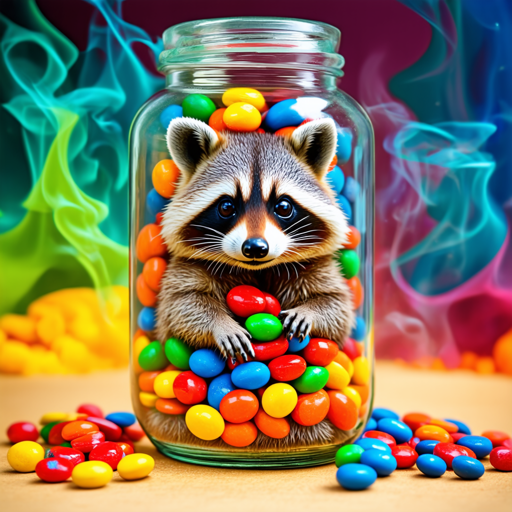

In [44]:
import torch
import random
import numpy as np

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
latents = np.random.randn(1, 16, 128, 128).astype(np.float32)
latents = torch.from_numpy(latents).to("cpu")
generator = torch.Generator(device="cpu").manual_seed(141)
prompt = "A raccoon trapped inside a glass jar full of colorful candies, the background is steamy with vivid colors"
num_inference_steps = 28
with torch.no_grad():
    image = pipe(prompt=prompt, negative_prompt='', num_inference_steps=num_inference_steps, generator=generator, guidance_scale=5).images[0]
image.resize((512, 512,))

## Convert models to Torch FX
[back to top ⬆️](#Table-of-contents:)

This step converts the pytorch models in the hf pipeline to Torch FX representation using the `capture_pre_autograd()` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.

In [4]:
import torch
from torch._export import capture_pre_autograd_graph
from nncf.torch.dynamic_graph.patch_pytorch import disable_patching

text_encoder_input = torch.ones((1, 77), dtype=torch.long)
text_encoder_kwargs = {}
text_encoder_kwargs['output_hidden_states'] = True

vae_encoder_input = torch.ones((1, 3, 128, 128))
vae_decoder_input = torch.ones((1, 16, 128, 128))

unet_kwargs = {}
unet_kwargs["hidden_states"] = torch.ones((2, 16, 128, 128))
unet_kwargs["timestep"] = torch.from_numpy(np.array([1,2], dtype=np.float32))
unet_kwargs["encoder_hidden_states"] = torch.ones((2, 154, 4096))
unet_kwargs["pooled_projections"] = torch.ones((2, 2048))
unet_kwargs["joint_attention_kwargs"] = None
unet_kwargs["return_dict"] = False

with torch.no_grad():
    with disable_patching():
        text_encoder = capture_pre_autograd_graph(pipe.text_encoder.eval(), args=(text_encoder_input,), kwargs=(text_encoder_kwargs))
        text_encoder_2 = capture_pre_autograd_graph(pipe.text_encoder_2.eval(), args=(text_encoder_input,), kwargs=(text_encoder_kwargs))
        pipe.vae.decoder = capture_pre_autograd_graph(pipe.vae.decoder, args=(vae_decoder_input,))
        pipe.vae.encoder = capture_pre_autograd_graph(pipe.vae.encoder, args=(vae_encoder_input,))
        vae = pipe.vae 
        transformer = capture_pre_autograd_graph(pipe.transformer.eval(), args=(), kwargs=(unet_kwargs))
models_dict = {}
models_dict['transformer'] = transformer
models_dict['vae'] = vae
models_dict['text_encoder'] = text_encoder
models_dict['text_encoder_2'] = text_encoder_2
del unet_kwargs
del vae_encoder_input
del vae_decoder_input
del text_encoder_input
del text_encoder_kwargs
del pipe

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, openvino


W1022 18:47:27.592000 130402839986624 torch/_export/__init__.py:95] +============================+
W1022 18:47:27.593000 130402839986624 torch/_export/__init__.py:96] |     !!!   WARNING   !!!    |
W1022 18:47:27.593000 130402839986624 torch/_export/__init__.py:97] +============================+
W1022 18:47:27.594000 130402839986624 torch/_export/__init__.py:98] capture_pre_autograd_graph() is deprecated and doesn't provide any function guarantee moving forward.
W1022 18:47:27.595000 130402839986624 torch/_export/__init__.py:99] Please switch to use torch.export instead.


## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `StableDiffusion3Pipeline` structure, the `transformer` model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the transformer part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy. That's why we use 4-bit weight compression for the rest of the pipeline to reduce memory footprint.

Please select below whether you would like to run quantization to improve model inference speed.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [5]:
from notebook_utils import quantization_widget
from sd3_quantization_helper import TRANSFORMER_INT8_PATH, TEXT_ENCODER_INT4_PATH, TEXT_ENCODER_2_INT4_PATH, TEXT_ENCODER_3_INT4_PATH, VAE_DECODER_INT4_PATH

to_quantize = quantization_widget()

to_quantize

Checkbox(value=True, description='Quantization')

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [6]:
# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

### Collect Calibration Dataset

In [36]:
%%skip not $to_quantize.value

import datasets
from tqdm.notebook import tqdm
from typing import Any, Dict, List
from sd3_torch_fx_helper import init_pipeline
from diffusers.models.transformers.transformer_sd3 import SD3Transformer2DModel

def disable_progress_bar(pipeline, disable=True):
    if not hasattr(pipeline, "_progress_bar_config"):
        pipeline._progress_bar_config = {'disable': disable}
    else:
        pipeline._progress_bar_config['disable'] = disable


class UNetWrapper(SD3Transformer2DModel):
    def __init__(self, transformer, config):
        super().__init__(**config)
        self.transformer = transformer
        self.captured_args = []

    def forward(self, *args, **kwargs):
        if np.random.rand() <= 0.7:
            self.captured_args.append((*args, *tuple(kwargs.values())))
        return self.transformer(*args, **kwargs)

def collect_calibration_data(pipe, calibration_dataset_size: int, num_inference_steps: int) -> List[Dict]:
    
    original_unet = pipe.transformer
    calibration_data = []
    disable_progress_bar(pipe)
    
    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True).shuffle(seed=42)

    pipe_copy = pipe
    transformer_config = dict(pipe.transformer.config)
    del transformer_config['model']
    wrapped_unet = UNetWrapper(pipe.transformer.model, transformer_config)
    pipe_copy.transformer = wrapped_unet
    # Run inference for data collection
    pbar = tqdm(total=calibration_dataset_size)
    for i, batch in enumerate(dataset):
        prompt = batch["caption"]
        print(prompt)
        if len(prompt) > pipe.tokenizer.model_max_length:
            continue
        # Run the pipeline
        pipe(prompt, num_inference_steps=num_inference_steps)
        calibration_data.extend(wrapped_unet.captured_args)
        wrapped_unet.captured_args = []
        pbar.update(len(calibration_data) - pbar.n)
        if pbar.n >= calibration_dataset_size:
            break

    disable_progress_bar(pipe, disable=False)
    pipe_copy.transformer = original_unet
    pipe = pipe_copy
    return calibration_data
if to_quantize:
    pipe = init_pipeline(models_dict, configs_dict)
    calibration_dataset_size = 300
    unet_calibration_data = collect_calibration_data(pipe,
                                                        calibration_dataset_size=calibration_dataset_size,
                                                        num_inference_steps=28)
    del pipe

<string>:37: FutureWarning: Accessing config attribute `model` directly via 'WrappedTransformer' object attribute is deprecated. Please access 'model' over 'WrappedTransformer's config object instead, e.g. 'unet.config.model'.


  0%|          | 0/10 [00:00<?, ?it/s]

a soldier clears the area outside the school .
a man is digging in soil and he is putting the soil into a wheelbarrow .
young couple in love embraces gently against the blue sky and white clouds
person before grooming left side view


In [37]:
%%skip not $to_quantize.value

import nncf
from nncf.quantization.advanced_parameters import AdvancedSmoothQuantParameters
from nncf.quantization.range_estimator import RangeEstimatorParametersSet

optimized_models_dict = models_dict
if to_quantize:
    with disable_patching():
        with torch.no_grad():
            nncf.compress_weights(optimized_models_dict['text_encoder'])
            nncf.compress_weights(optimized_models_dict['text_encoder_2'])
            nncf.compress_weights(optimized_models_dict['vae'].encoder)
            nncf.compress_weights(optimized_models_dict['vae'].decoder)
            optimized_models_dict['transformer'] = nncf.quantize(
                model=optimized_models_dict['transformer'],
                calibration_dataset=nncf.Dataset(unet_calibration_data),
                subset_size=len(unet_calibration_data),
                model_type=nncf.ModelType.TRANSFORMER,
                ignored_scope=nncf.IgnoredScope(names=['conv2d']),
                advanced_parameters=nncf.AdvancedQuantizationParameters(weights_range_estimator_params=RangeEstimatorParametersSet.MINMAX, activations_range_estimator_params=RangeEstimatorParametersSet.MINMAX)
            )
del models_dict

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (75 / 75)              │ 100% (75 / 75)                         │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (195 / 195)            │ 100% (195 / 195)                       │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (31 / 31)              │ 100% (31 / 31)                         │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

INFO:nncf:Statistics of the bitwidth distribution:
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┑
│ Weight compression mode   │ % all parameters (layers)   │ % ratio-defining parameters (layers)   │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┥
│ int8_asym                 │ 100% (39 / 39)              │ 100% (39 / 39)                         │
┕━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┙


Output()

Output()

Output()

INFO:nncf:1 ignored nodes were found by names in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 7 conv2d
9 add__tensor



Output()

Output()

In [38]:
%%skip not $to_quantize.value

optimized_models_dict['text_encoder'] = torch.compile(optimized_models_dict['text_encoder'], backend='openvino')
optimized_models_dict['text_encoder_2'] = torch.compile(optimized_models_dict['text_encoder_2'], backend='openvino')
optimized_models_dict['vae'].encoder = torch.compile(optimized_models_dict['vae'].encoder, backend='openvino')
optimized_models_dict['vae'].decoder = torch.compile(optimized_models_dict['vae'].decoder, backend='openvino')
optimized_models_dict['transformer'] = torch.compile(optimized_models_dict['transformer'], backend='openvino')

### Create Optimized Pipeline

Initialize the optimized pipeline using the optimized models 

In [39]:
%%skip not $to_quantize.value

opt_pipe = init_pipeline(optimized_models_dict, configs_dict)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

### Inference for Compilation

Run inference with single step to compile the model

In [40]:
%%skip not $to_quantize.value

# Warmup the model for initial compile
with torch.no_grad():
    image = opt_pipe(prompt=prompt, negative_prompt='', num_inference_steps=1, generator=generator).images[0]

  0%|          | 0/1 [00:00<?, ?it/s]

/home/user/Downloads/ov_notebooks_sd3/openvino_notebooks/notebooks/stable-diffusion-v3/sd3_torch_fx_helper.py:47: FutureWarning: Accessing config attribute `model` directly via 'WrappedTransformer' object attribute is deprecated. Please access 'model' over 'WrappedTransformer's config object instead, e.g. 'unet.config.model'.
  return self.model(*args, **kwargs)


### Check File Size

In [41]:
%%skip not $to_quantize.value

def get_model_size(models):
    total_size = 0
    for model in models:
        param_size = 0
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        buffer_size = 0
        for buffer in model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()

        model_size_mb = (param_size + buffer_size) / 1024**2

        total_size += model_size_mb
    return total_size
optimized_model_size = get_model_size([opt_pipe.transformer])
original_model_size = get_model_size([models_dict['transformer']])

print(f'Optimized Transformer Size: {optimized_model_size} MB')
print(f'Original Transformer Size: {original_model_size} MB')
print(f'Compression Rate: {original_model_size / optimized_model_size:.3f} MB')

Transformer Size:
2162.203857421875


  0%|          | 0/28 [00:00<?, ?it/s]

/home/user/Downloads/ov_notebooks_sd3/openvino_notebooks/notebooks/stable-diffusion-v3/sd3_torch_fx_helper.py:47: FutureWarning: Accessing config attribute `model` directly via 'WrappedTransformer' object attribute is deprecated. Please access 'model' over 'WrappedTransformer's config object instead, e.g. 'unet.config.model'.
  return self.model(*args, **kwargs)


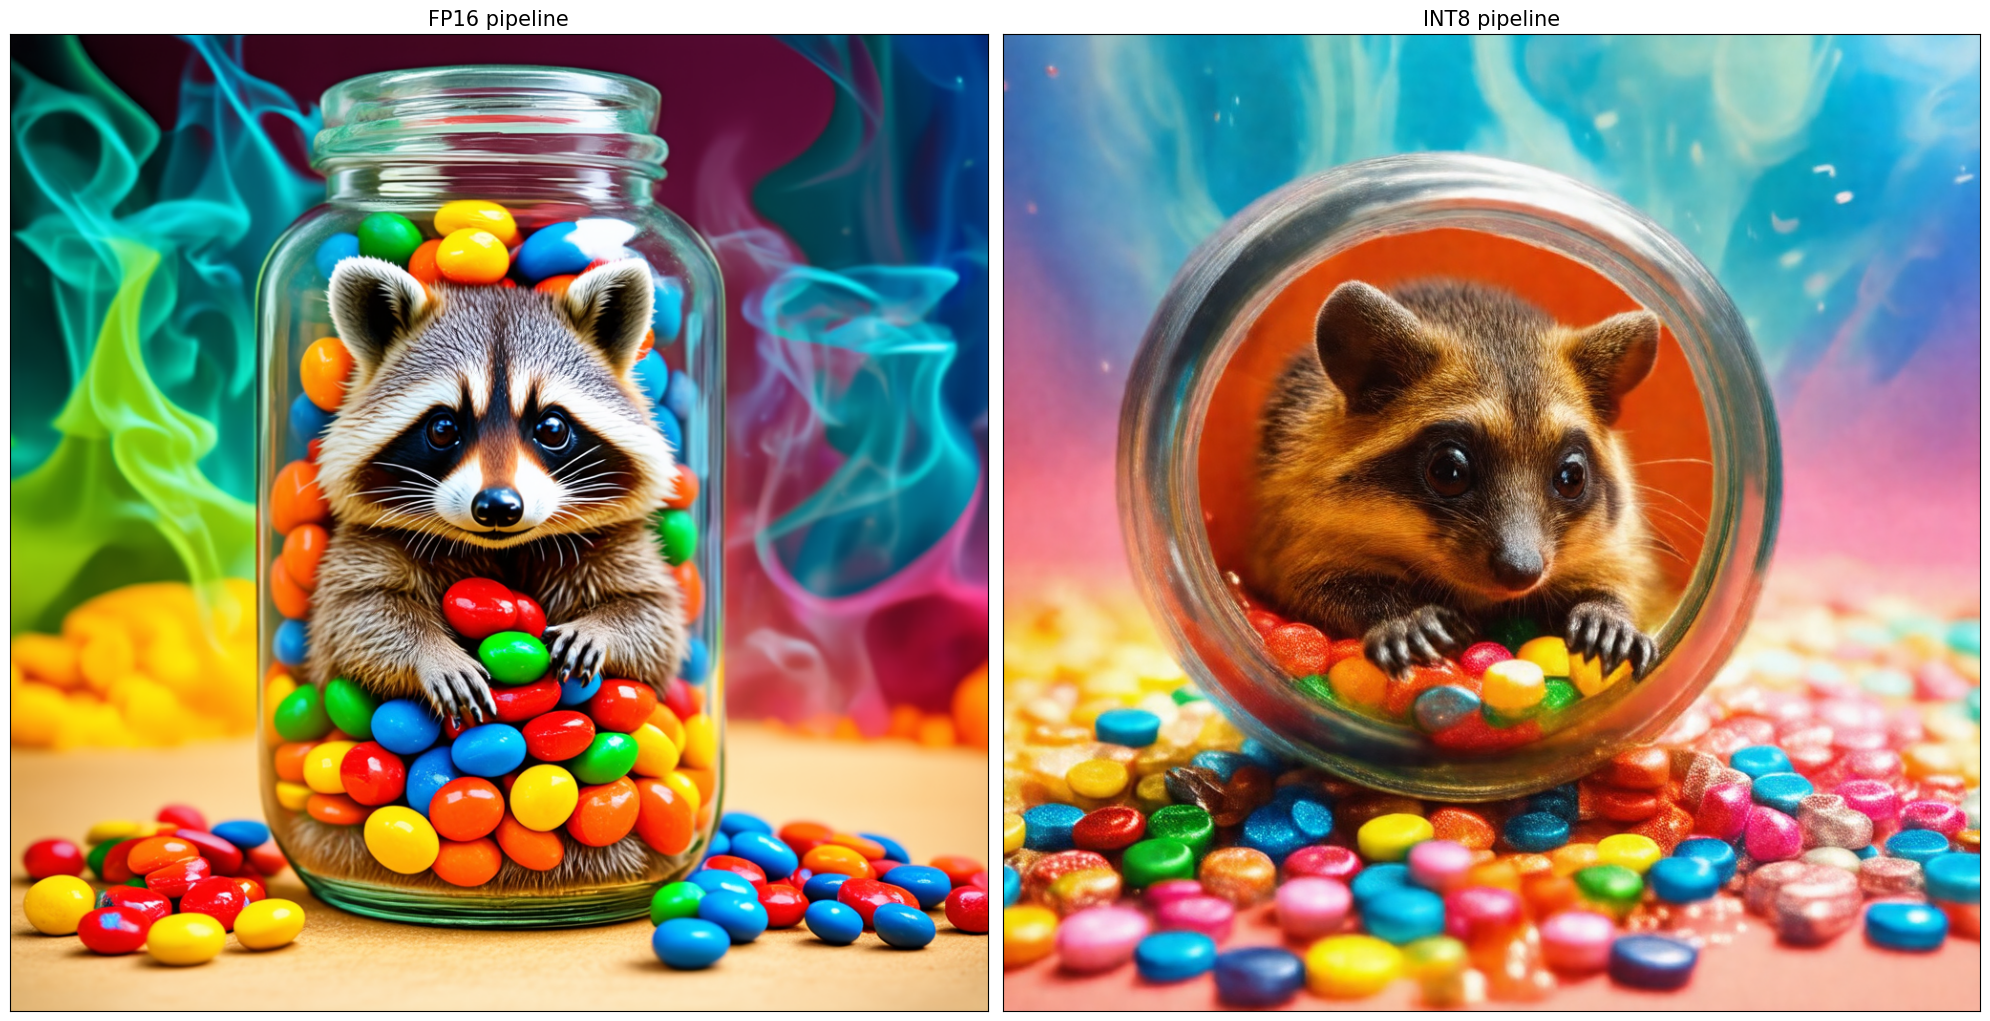

In [45]:
%%skip not $to_quantize.value

from sd3_quantization_helper import visualize_results

opt_image = opt_pipe(
    prompt,
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=5,
    generator=generator,
    latents=latents
    ).images[0]

visualize_results(image, opt_image)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

Please select below whether you would like to use the quantized models to launch the interactive demo.

In [ ]:
from sd3_helper import get_pipeline_selection_option

use_quantized_models = get_pipeline_selection_option(optimized_models_dict)

use_quantized_models

In [ ]:
from gradio_helper import make_demo

fx_pipe = init_pipeline(models_dict if not to_quantize.value else optimized_models_dict, device.value, False)
demo = make_demo(fx_pipe, False)

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)